<a href="https://colab.research.google.com/github/YulianaPoliakova/propaganda-detection-ml/blob/main/2023_Project_prop_tech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of Persuasion Techniques in multilingual Online News

Given the textual content of an article, identify the techniques used in it (multilabel classification problem).

# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/huggingface/transformers

In [ ]:
! pip install  "datasets" "pytorch-lightning" 

In [ ]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import torch
from torch.utils.data import (
    Dataset, TensorDataset,
    DataLoader, RandomSampler,
    SequentialSampler)
import torch.nn as nn
import torchmetrics
import torchmetrics.functional as func

from pytorch_lightning import (
    LightningDataModule, LightningModule, 
    Trainer, seed_everything)
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Callback
from transformers import (
    AdamW,
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    get_constant_schedule_with_warmup,
    MMBTConfig,
    MMBTModel,
    VisualBertModel,
    AutoModelForCausalLM
)
from torch.optim.lr_scheduler import MultiStepLR

/usr/local/lib/python3.8/dist-packages/neptune/internal/backends/hosted_client.py:48: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/neptune.py:39: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune import new as neptune


In [ ]:
from transformers import BitsAndBytesConfig

In [ ]:
from torchvision import transforms, models
from torchvision.models import detection
import cv2
from PIL import Image
from tqdm import tqdm
import csv
import gc
import json
import re
import numpy as np
import pandas as pd
import random
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import sklearn.metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

In [ ]:
from accelerate import init_empty_weights

# Helper functions

In [ ]:
def plot_confusion_matrix(cm, num_classes=19, title='confusion matrix', 
                          classes=['negative', 'positive'], cmap=plt.cm.YlGn):

    title = title

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(num_classes-0.5, -0.5)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
def plot_confusion_multi(all_cm, classes):
  assert len(all_cm)==len(classes)
  label =0
  for cm in all_cm:
    class_name=classes[label]
    title="confusion matrix for "+str(class_name)
    plot_confusion_matrix(cm,2,title=title)
    label=label+1

In [ ]:
AVAIL_GPUS = 0
if torch.cuda.is_available():       
    device = torch.device("cuda")
    AVAIL_GPUS = torch.cuda.device_count()
    print(f'There are {AVAIL_GPUS} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
                                                                                                                                                                                                                                            
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
def make_dataframe(input_folder, labels_fn=None):
    # MAKE TXT DATAFRAME
    text = []
    for fil in tqdm(filter(lambda x: x.endswith('.txt'), os.listdir(input_folder))):
      if fil[1] == "_":
        fil = fil[2:]
      iD = fil[7:].split('.')[0]
      lines = list(enumerate(open(input_folder +'/' + fil, 'r', encoding='utf-8').read().splitlines(), 1))
      text.extend([(iD,) + line for line in lines])

    df_text = pd.DataFrame(text, columns=['id', 'line', 'text'])
    df_text.id = df_text.id.apply(int)
    df_text.line = df_text.line.apply(int)
    df_text = df_text[df_text.text.str.strip().str.len() > 0].copy()
    df_text = df_text.set_index(['id', 'line'])

    df = df_text

    if labels_fn:
        # MAKE LABEL DATAFRAME
        labels = pd.read_csv(labels_fn, sep='\t', encoding='utf-8', header=None)
        labels = labels.rename(columns={0: 'id', 1: 'line', 2: 'labels'})
        labels = labels.set_index(['id', 'line'])
        labels = labels[labels.labels.notna()].copy()

        # JOIN
        df = labels.join(df_text)[['text', 'labels']]

    return df

#Import Data

## Russian Dataset

In [ ]:
folder_train = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ru/train-articles-subtask-3'
folder_dev = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ru/dev-articles-subtask-3'
labels_train_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ru/train-labels-subtask-3.txt'
labels_dev_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ru/dev-labels-subtask-3.txt'
out_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/output.txt'

# Read Data
print('Loading dataset...',  make_dataframe(folder_train, labels_train_fn))
train = make_dataframe(folder_train, labels_train_fn)
train_data = train
val_data = make_dataframe(folder_dev, labels_dev_fn)

249it [00:00, 560.10it/s]


Loading dataset...                                                          text  \
id    line                                                      
241   1     Кургинян: под прикрытием демократии США привод...   
      3     США используют слова о демократии для того, чт...   
      5     «Теперь говорится, что у нас ось зла — авторит...   
      6     Он отметил, что подобные лидеры не гнушались о...   
      8     «Про всех остальных говорили то же самое. Чан ...   
...                                                       ...   
24191 1       Начался развал НАТО: альянс покинул Лихтенштейн   
      3     Всё больше стран стараются дистанцироваться от...   
      5     «Мы небольшая европейская страна, нам чужды ми...   
      7     Как отмечают эксперты, Лихтенштейн может стать...   
      9     «Для простого бюргера важно то, как живёт он и...   

                                                       labels  
id    line                                                     
241   1

249it [00:00, 789.39it/s]
59it [00:00, 1003.11it/s]


## English Dataset

In [ ]:
folder_train = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/en/train-articles-subtask-3'
folder_dev = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/en/dev-articles-subtask-3'
labels_train_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/en/train-labels-subtask-3.txt'
labels_dev_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/en/dev-labels-subtask-3.txt'
out_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/output.txt'

# Read Data
print('Loading dataset...',  make_dataframe(folder_train, labels_train_fn))
train = make_dataframe(folder_train, labels_train_fn)
train_data = train
val_data = make_dataframe(folder_dev, labels_dev_fn)

447it [00:03, 134.54it/s]


Loading dataset...                                                              text  \
id        line                                                      
111111111 3     Geneva - The World Health Organisation chief o...   
          3     Geneva - The World Health Organisation chief o...   
          5     "The next transmission could be more pronounce...   
          5     "The next transmission could be more pronounce...   
          13    But Tedros voiced alarm that "plague in Madaga...   
...                                                           ...   
999001970 4     Also the Left killed comedy. This is what its ...   
          5     Saturday Night Live writer and comedian Nimesh...   
          6     That's what Columbia snowflakes thought was of...   
          8     Comrades, these jokes you have been listening ...   
          13            I'm sure Patel felt very, like, accepted.   

                                                         labels  
id        line   

447it [00:00, 633.26it/s]
90it [00:16,  5.33it/s]


## German Dataset

In [ ]:
folder_train = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ge/train-articles-subtask-3'
folder_dev = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ge/dev-articles-subtask-3'
labels_train_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ge/train-labels-subtask-3.txt'
labels_dev_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/ge/dev-labels-subtask-3.txt'
out_fn = '/content/drive/MyDrive/semeval2023task3bundle-v3/data/output.txt'

# Read Data
print('Loading dataset...',  make_dataframe(folder_train, labels_train_fn))
train = make_dataframe(folder_train, labels_train_fn)
train_data = train
val_data = make_dataframe(folder_dev, labels_dev_fn)

132it [00:00, 140.98it/s]


Loading dataset...                                                         text  \
id   line                                                      
221  1     USA verbreiten gefakte Geschichten, um Russlan...   
     3     Die Genies (nicht) im Nationalen Sicherheitsra...   
     5     WASHINGTON – Die Vereinigten Staaten haben Inf...   
2210 3     Wladimir Putin, der Präsident Russlands, ist d...   
     5     Trotz dieser harten Charakterisierungen des ru...   
...                                                      ...   
2299 9     »Man muss davon ausgehen, dass sich der Neubau...   
     15    Die Tageszeitung junge Welt stört die Herrsche...   
     21                Lindners Streichoffertevom 08.07.2022   
     23                  Watschn für A-20-Planvom 08.07.2022   
     25            »Ab Tutzing alles im Arsch«vom 08.07.2022   

                                                      labels  
id   line                                                     
221  1     Loaded_Lang

132it [00:00, 1081.06it/s]
45it [00:08,  5.08it/s]


# PTC: Propaganda Techniques corpus 


## PTC - Training 

### Dataset

In [ ]:
class PTCDataset(Dataset):
    def __init__(self, input_id, attention, labels):
        self.attention = attention
        self.input_id = input_id
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        attention = self.attention[idx]
        label = self.labels[idx]
        input_id = self.input_id[idx]
        sample = {"attention_mask": attention,
                  "input_ids": input_id, "labels": label}
        return sample

In [ ]:
train_data = train_data.set_index('text').labels.str.split(',', expand=True).stack().reset_index(level=1, drop=True).reset_index()
val_data = val_data.set_index('text').labels.str.split(',', expand=True).stack().reset_index(level=1, drop=True).reset_index()

train_data['label'] = train_data[0]
train_data = train_data.drop(columns=[0])

val_data['label'] = val_data[0]
val_data = val_data.drop(columns=[0])

labels_count = train_data['label'].nunique()

Overview of the dataset characteristics and of the distribution of the classes.

In [ ]:
train_data

,text,label
0,"USA verbreiten gefakte Geschichten, um Russlan...",Loaded_Language
1,"USA verbreiten gefakte Geschichten, um Russlan...",Name_Calling-Labeling
2,"USA verbreiten gefakte Geschichten, um Russlan...",Questioning_the_Reputation
3,Die Genies (nicht) im Nationalen Sicherheitsra...,Loaded_Language
4,Die Genies (nicht) im Nationalen Sicherheitsra...,Name_Calling-Labeling
...,...,...
3048,Die Tageszeitung junge Welt stört die Herrsche...,Appeal_to_Fear-Prejudice
3049,Die Tageszeitung junge Welt stört die Herrsche...,Appeal_to_Values
3050,Lindners Streichoffertevom 08.07.2022,Name_Calling-Labeling
3051,Watschn für A-20-Planvom 08.07.2022,Name_Calling-Labeling


In [ ]:
train_data.describe()

,text,label
count,3053,3053
unique,1245,23
top,Doch Emmanuel Macron hält sich an die alte Dok...,Name_Calling-Labeling
freq,11,734


In [ ]:
frequences = train_data.groupby(['label']).size()
frequences

label
Appeal_to_Authority                 225
Appeal_to_Fear-Prejudice            182
Appeal_to_Hypocrisy                 136
Appeal_to_Popularity                 63
Appeal_to_Time                       11
Appeal_to_Values                     73
Causal_Oversimplification            33
Consequential_Oversimplification     35
Conversation_Killer                 121
Doubt                               288
Exaggeration-Minimisation           157
False_Dilemma-No_Choice              41
Flag_Waving                          65
Guilt_by_Association                122
Loaded_Language                     242
Name_Calling-Labeling               734
Obfuscation-Vagueness-Confusion      62
Questioning_the_Reputation          310
Red_Herring                          30
Repetition                            8
Slogans                              87
Straw_Man                            15
Whataboutism                         13
dtype: int64

<AxesSubplot:xlabel='label'>

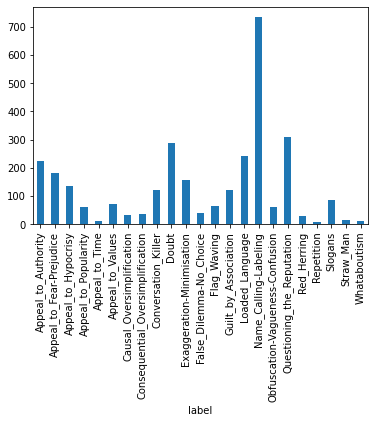

In [ ]:
frequences.plot(kind='bar')

## Filter < 50

In [ ]:
# filter the dataframe to only include labels with frequency < 50
freq_less_than_50 = list(train_data.groupby('label').filter(lambda x: len(x) < 50)['label'].unique())

In [ ]:
freq_less_than_50

['Consequential_Oversimplification',
 'False_Dilemma-No_Choice',
 'Causal_Oversimplification',
 'Appeal_to_Time',
 'Straw_Man',
 'Whataboutism',
 'Red_Herring',
 'Repetition']

In [ ]:
rows_to_remove = train_data['label'].str.contains('|'.join(freq_less_than_50))


train_data_small = train_data[rows_to_remove]
train_data_trimmed = train_data[~rows_to_remove]

rows_to_remove = val_data['label'].str.contains('|'.join(freq_less_than_50))

In [ ]:
train_data = train_data_trimmed
val_data = val_data[~rows_to_remove]

labels_count = train_data['label'].nunique()

In [ ]:
train_data.describe()

,text,label
count,2867,2867
unique,1223,15
top,Doch Emmanuel Macron hält sich an die alte Dok...,Name_Calling-Labeling
freq,10,734


<AxesSubplot:xlabel='label'>

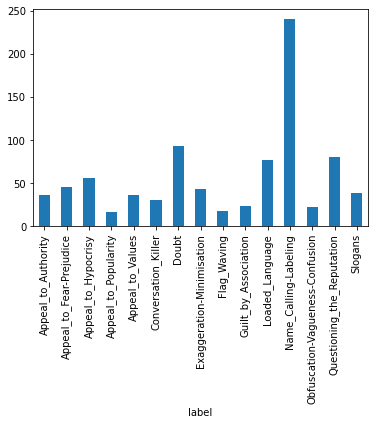

In [ ]:
val_data.describe()
frequences = val_data.groupby(['label']).size()
frequences.plot(kind='bar')

<AxesSubplot:xlabel='label'>

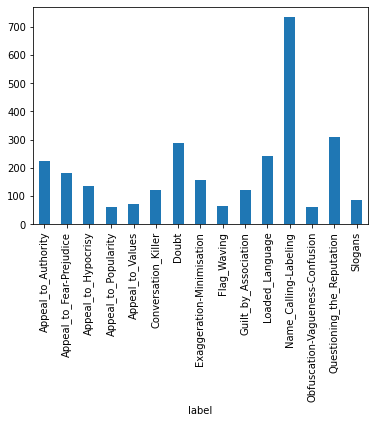

In [ ]:
train_data.describe()
frequences = train_data.groupby(['label']).size()
frequences.plot(kind='bar')

## Pre-trained Transformer Name

This section is used to choose which pre-trained model to load from HuggingFace library.

In [ ]:
#pretrained_transformer_name = "microsoft/mdeberta-v3-base"
#pretrained_transformer_name = "microsoft/deberta-base"
#pretrained_transformer_name = "albert-base-v2"
#pretrained_transformer_name = "roberta-base"
#pretrained_transformer_name = "roberta-large"
pretrained_transformer_name = "DeepPavlov/rubert-base-cased"

checkpoint_name= pretrained_transformer_name.replace("/","_")

## NeptuneAI

In [ ]:
!pip install neptune-client torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install neptune-contrib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import neptune.new as neptune
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve

In [ ]:
run = neptune.init_run(
    project="yuliana.poliakova/ba-thesis-experiments",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyZGY1OTMzMS05NjBkLTQzYmItODMwMy1mMTJkODllNjQzZTYifQ==",
)

params = {
    "bs": 16,
    "num_epoch": 1,
    "n_classes": labels_count,
    "learning_rate": 2e-5,
    "adam_epsilon" : 1e-8,
    "model_name": pretrained_transformer_name
}
run["parameters"] = params

#run = neptune.init_run(source_files=["BA_Project.ipynb"]) 


<ipython-input-32-2d356921b0b3>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/yuliana.poliakova/ba-thesis-experiments/e/BAT-27


In [ ]:
class NeptuneMetrics(Callback):
    def __init__(self, neptune_experiment, validation, current_fold):
        super(NeptuneMetrics, self).__init__()
        self.exp = neptune_experiment
        self.validation = validation
        self.curFold = current_fold

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]
        val_predict = (np.asarray(self.model.predict(self.validation[0]))).round()

        val_f1 = round(f1_score(val_targ, val_predict), 4)
        val_recall = round(recall_score(val_targ, val_predict), 4)
        val_precision = round(precision_score(val_targ, val_predict), 4)

        self.val_f1s.append(val_f1)
        self.val_recalls.append(val_recall)
        self.val_precisions.append(val_precision)

        print(f' — val_f1: {val_f1} — val_precision: {val_precision}, — val_recall: {val_recall}')

        ### Send the performance metrics to Neptune for tracking (new version) ###
	    self.exp['Epoch End Loss'].log(logs['loss'])
        self.exp['Epoch End F1-score'].log(val_f1)
        self.exp['Epoch End Precision'].log(val_precision)
        self.exp['Epoch End Recall'].log(val_recall)

        if self.curFold == 4:
            ### Log Epoch End metrics values for each step in the last CV fold ###
            msg = f' End of epoch {epoch} val_f1: {val_f1} — val_precision: {val_precision}, — val_recall: {val_recall}'
            ### Neptune new version
            self.exp[f'Epoch End Metrics (each step) for fold {self.curFold}'] = msg

TabError: ignored

## Define LightningDataModule

In [ ]:
class PTCDataModule(LightningDataModule):
    def __init__(
        self,
        train_data,
        val_data,
        model_name: str = "microsoft/mdeberta-v3-base",
        batch_size: int = 32,
        **kwargs,
    ):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size
        self.num_labels = labels_count
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, do_lower_case=False)
        self.le = preprocessing.LabelEncoder()

    def setup(self, stage: str = None):
        self.X_train = self.train_data.text.values
        self.le.fit(self.train_data.label.values)
        y_train = self.le.transform(self.train_data.label.values)

        self.X_val = self.val_data.text.values
        y_val = self.le.transform(self.val_data.label.values)

        #self.max_length = self.maxLen()
        self.max_length = 512

        self.X_train_enc, self.X_train_attention = self.preprocessing(
            self.X_train)
        self.X_val_enc, self.X_val_attention = self.preprocessing(
            self.X_val)

        self.y_train = torch.tensor(y_train)
        self.y_val = torch.tensor(y_val)

    def prepare_data(self):
        return

    def train_dataloader(self):
        data = PTCDataset(self.X_train_enc,
                          self.X_train_attention, self.y_train)
        train_dataloader = DataLoader(data, batch_size=self.batch_size, num_workers = 4)
        return train_dataloader

    def val_dataloader(self):
        data = PTCDataset(self.X_val_enc, self.X_val_attention, self.y_val)
        val_dataloader = DataLoader(data, batch_size=self.batch_size, num_workers = 4)
        return val_dataloader

    def preprocessing(self, data):
        input_ids = []
        attention_masks = []

        for sent in data:
            encoded_sent = self.tokenizer.encode_plus(
                text=sent,
                add_special_tokens=True,
                max_length=self.max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True
            )

            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)

        return input_ids, attention_masks

    def maxLen(self):
        X_all = np.concatenate([self.X_train, self.X_val])

        encoded_X = [
            self.tokenizer.encode(
                sent,
                add_special_tokens=True
            ) for sent in X_all
        ]

        max_len = max([len(sent) for sent in encoded_X])
        return max_len


TODO: Here is where max length should be accepted

##Evaluation


Class that implements the callback that prints the metrics that are used to evaluate a model.

In [ ]:
class PTCEvaluateCallback(Callback):
    def on_fit_end(self, trainer, model):
        print("Fit end: Evaluation....")

        all_predictions = model.predictions.detach().cpu().numpy().astype(int)
        all_labels = model.labels.detach().cpu().numpy().astype(int)

        classes = model.le.classes_

        #neptune.log_image('predictions', all_predictions)
        #neptune.log_image('labels', all_labels)

        run["F1-micro"].append(f1_score(all_labels,
              all_predictions, average='micro', zero_division=1))
        run["F1-macro"].append(f1_score(all_labels,
              all_predictions, average='macro', zero_division=1))

        print("F1-micro: {}".format(f1_score(all_labels,
              all_predictions, average='micro', zero_division=1)))
        print("F1-macro: {}".format(f1_score(all_labels,
              all_predictions, average='macro', zero_division=1)))

        print(classification_report(all_labels, all_predictions, labels=[
              i for i in range(model.num_classes)], target_names=classes))

        #conf_mat = confusion_matrix(all_labels, all_predictions)
        #plot_confusion_matrix(conf_mat, classes=classes)

        return


In [ ]:
class CLSExtractor(nn.Module):
    def __init__(self, name):
        super(CLSExtractor, self).__init__()
        self.isCLSLast = (True if name == 'xlnet-base-cased' else False)

    def forward(self, x):
        if(self.isCLSLast):
            return x[0][:, -1, :]
        else:
            return x[0][:, 0, :]

In [ ]:
class PTCTransformer(LightningModule):
    def __init__(
        self,
        le,
        y_train=None,
        num_classes: int = labels_count,
        model_name_or_path: str = "microsoft/mdeberta-v3-base",
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        batch_size: int = 32,
        threshold=0.5,
        **kwargs,
    ):
        super().__init__()

        self.num_classes = num_classes

        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon

        self.save_hyperparameters()

        self.le = le

        self.loss = nn.CrossEntropyLoss()
        #self.loss = FocalLoss()
        #self.loss = WeightedCELoss(y_train)
        self.threshold = threshold
        self.acc = torchmetrics.Accuracy(task='multiclass', num_classes=19)

        self.labels = torch.Tensor(device=self.device)
        self.predictions = torch.Tensor(device=self.device)

        D_in, H, D_out = 768, 96, num_classes
        #self.transformer = AutoModel.from_pretrained(model_name_or_path)
        # Load 8-bit with threshold 
        config = AutoConfig.from_pretrained(model_name_or_path)

        with init_empty_weights():
            model = AutoModelForCausalLM.from_config(config)

        quantization_config = BitsAndBytesConfig(
            llm_int8_threshold=10.0,
        )

        self.transformer = AutoModelForCausalLM.from_pretrained(
            model_name_or_path,
            device_map="auto",
            quantization_config=quantization_config,
        )

        self.extractor = CLSExtractor(model_name_or_path)

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

    def forward(self, **inputs):
        plm_output = self.transformer(input_ids=inputs["input_ids"],
                                      attention_mask=inputs["attention_mask"])

        last_hidden_state_cls = self.extractor(plm_output)

        logits = self.classifier(last_hidden_state_cls)
        
        # Try to add preictions threshold here
        probs = torch.sigmoid(logits)
        predictions = (probs >= self.threshold).long().float()

        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        logits = self(**batch)
        loss = self.loss(logits, labels)
        predictions = torch.argmax(torch.softmax(logits, dim=1), axis=1)
        acc = self.acc(predictions, labels)
        return {"loss": loss, "accuracy": acc}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        val_loss = self.loss(logits, labels)
        predictions = torch.argmax(logits, axis=1)
        acc = self.acc(predictions, labels)

        return {"loss": val_loss, "accuracy": acc, 
                "predictions": predictions, "labels": labels}

    def validation_step_end(self, outputs):
        return outputs

    def validation_epoch_end(self, outputs):
        if(self.current_epoch == self.trainer.max_epochs - 1):
            labels = [x["labels"] for x in outputs]
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in outputs]
            self.predictions = torch.cat(predictions, dim=0)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(),
                          lr=self.learning_rate, eps=self.adam_epsilon)
        return optimizer



##Training 


In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
torch.set_float32_matmul_precision('medium')

In [ ]:
seed_everything(21)
dm = PTCDataModule(train_data, val_data,
                   model_name=pretrained_transformer_name, batch_size=16)
dm.setup()

INFO:lightning_fabric.utilities.seed:Global seed set to 21
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
model = PTCTransformer(
    dm.le, dm.y_train, model_name_or_path=pretrained_transformer_name)

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


NameError: ignored

In [ ]:
trainer = Trainer(max_epochs=1, gpus=AVAIL_GPUS, logger=None, callbacks=[
                  PTCEvaluateCallback()])  

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
trainer.fit(model, dm)

#run.stop()

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will b

Sanity Checking: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Fit end: Evaluation....
F1-micro: 0.27987897125567324
F1-macro: 0.029156816390858944
                                  precision    recall  f1-score   support

        Appeal_to_Fear-Prejudice       0.00      0.00      0.00        14
             Appeal_to_Hypocrisy       0.00      0.00      0.00        22
                  Appeal_to_Time       0.00      0.00      0.00         1
                Appeal_to_Values       0.00      0.00      0.00         9
       Causal_Oversimplification       0.00      0.00      0.00         7
Consequential_Oversimplification       0.00      0.00      0.00        14
             Conversation_Killer       0.00      0.00      0.00        30
                           Doubt       0.00      0.00      0.00       126
       Exaggeration-Minimisation       0.00      0.00      0.00        32
                     Flag_Waving       0.00      0.00      0.00        12
                 Loaded_Language       0.28      1.00      0.44       185
           Name_Calling-La

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# trainer.save_checkpoint(PTC_checkpoints+"PTC_"+checkpoint_name+"_FL.ckpt")

In [ ]:
run.stop()